<a href="https://colab.research.google.com/github/krystaldowling/MAST30034_Final_Project-/blob/ml_GloVe/glove_mean_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import nltk
# nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.base import TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

In [3]:
class MeanEmbeddingTransformer(TransformerMixin):
    
    def __init__(self):
        self._vocab, self._E = self._load_words()
        
    
    def _load_words(self):
        '''
        load in pre-trained glove embeddings
        '''
        E = {}
        vocab = []

        with open('/content/drive/My Drive/Data/glove.6B.100d.txt', 'r', encoding="utf8") as file:
            for i, line in enumerate(file):
                l = line.split(' ')
                if l[0].isalpha():
                    v = [float(i) for i in l[1:]]
                    E[l[0]] = np.array(v)
                    vocab.append(l[0])
        return np.array(vocab), E            

    
    def _get_word(self, v):
        for i, emb in enumerate(self._E):
            if np.array_equal(emb, v):
                return self._vocab[i]
        return None
    
    def _doc_mean(self, doc):
        '''
        find mean embedding for each text article
        '''
        return np.mean(np.array([self._E[w.lower().strip()] for w in doc if w.lower().strip() in self._E]), axis=0)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([self._doc_mean(doc) for doc in X])
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [4]:
def plot_roc(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
def print_scores(clf, X_train, y_train, X_test, y_test):
    '''
    fit model to training and testing data - calculate accuracy, f1 and auc score
    '''
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = clf.score(X_test, y_test)
    print('accuracy score',  acc)
    print('F1 score: {:3f}'.format(f1_score(y_test, y_pred)))
    print('AUC score: {:3f}'.format(roc_auc_score(y_test, y_pred)))

In [5]:
news_data = pd.read_csv('/content/drive/My Drive/Data/final_preproccessed_data.csv')

In [6]:
X = news_data['text'].values
y = news_data['label'].values

In [7]:
def tokenize_and_transform(X):
    '''
    tokenise the text data and transform with the embeddings
    '''
    text = X
    tok_text = [word_tokenize(doc) for doc in text]
    met = MeanEmbeddingTransformer()
    X_transform = met.fit_transform(tok_text)
    return X_transform

In [8]:
X_transform = tokenize_and_transform(X)

In [15]:
# np.savetxt('/content/drive/My Drive/Data/data_glove_embed.csv', X_transform, delimiter=',')

X_transform = np.loadtxt('/content/drive/My Drive/Data/data_glove_embed.csv', delimiter=',')

In [9]:
text_train, text_test, label_train, label_test = train_test_split(X_transform,
                                                    y, test_size = 0.3, random_state=80)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy score 0.7634226291398214
F1 score: 0.714500
AUC score: 0.753827


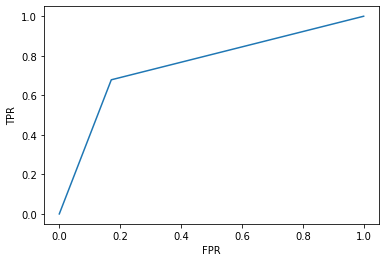

In [10]:
lr = LogisticRegression()
print_scores(lr, text_train, label_train, text_test, label_test)
plot_roc(lr, text_test, label_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


{'C': 1, 'solver': 'liblinear'}
best score: 0.721082


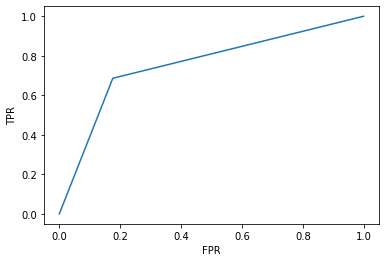

In [15]:
gs = GridSearchCV(LogisticRegression(), 
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1], 
                         'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}, 
                          scoring="accuracy", cv=4)
gs = gs.fit(X_transform, y)
print(gs.best_params_)
print('best score: {:3f}'.format(gs.best_score_))
plot_roc(gs, X_transform, y)

accuracy score 0.7633095964733808
F1 score: 0.714403
AUC score: 0.753726


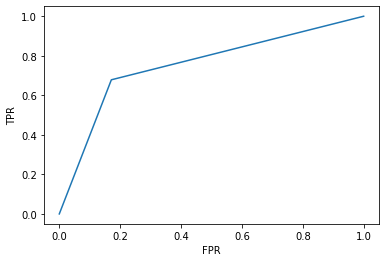

In [14]:
lr_best = LogisticRegression(C = 1, solver='liblinear')
print_scores(lr_best, text_train, label_train, text_test, label_test)
plot_roc(lr_best, text_test, label_test)

{'kernel': 'poly'}
best score: 0.732510


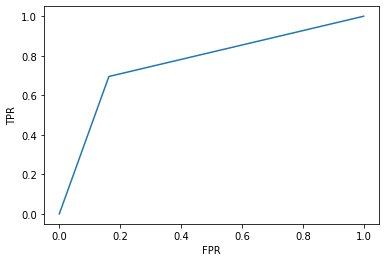

In [19]:
gs = GridSearchCV(SVC(), 
             param_grid={'kernel':['linear', 'poly', 'rbf', 'sigmoid']}, 
                          scoring="accuracy", cv=4)
gs = gs.fit(X_transform, y)
print(gs.best_params_)
print('best score: {:3f}'.format(gs.best_score_))
plot_roc(gs, X_transform, y)

accuracy score 0.7712218831242229
F1 score: 0.723043
AUC score: 0.761418


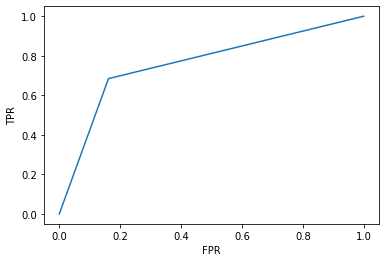

In [20]:
svm = SVC(kernel = 'poly')
print_scores(svm, text_train, label_train, text_test, label_test)
plot_roc(svm, text_test, label_test)